# Reconhecimento facial
<small> Guilherme Monteiro e Vinícius Cavalcante <small>

Neste Notebook será aberta uma versão do classificador SVM com kernel Gaussiano já treinada para validação com dados que não foram usados no treinamento.

# Abrindo o PCA e o modelo SVM com kernel gaussiano treinado

In [15]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
from google.colab import files
import os
from datetime import timedelta

In [16]:
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

O nome do diretório é Files

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

patients_target_pain = os.listdir('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Test')
print(patients_target_pain)

Mounted at /content/gdrive
['Baixo', 'Medio', 'Alto']


In [18]:
#patients_target_pain.remove('.ipynb_checkpoints')
n_classes = len(patients_target_pain)
print(f'Nosso problema terá {n_classes} classes.')

Nosso problema terá 3 classes.


In [19]:
basedir = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Test/'

In [20]:
!ls gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train

Alto  Baixo  Medio


In [21]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pickle as pk

with_resize = False
if with_resize:
  resize, altura_lfw, largura_lfw = 0.5, 62, 47
else:
  resize, altura_lfw, largura_lfw = 1, 125, 94

pca = pk.load(open('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/pca_'+str(resize)+'.pkl', 'rb'))
model = pk.load(open('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/model_clf_SVM_Gaussiano_'+str(resize)+'.sav', 'rb'))

# Validação com dados que não fizeram parte do treinamento

Validar a SVM com um vídeo de esforço que não entrou para o treinamento da rede.

In [22]:
basedir_val = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Test/' # val stands for validation

patients_val_data = []
patients_val_target = []
for i in range(len(patients_target_pain)):
  included_extensions = ['jpg','jpeg']
  imagens = [fn for fn in os.listdir(basedir_val+patients_target_pain[i]+'/')
              if any(fn.endswith(ext) for ext in included_extensions)]
  for j in range(len(imagens)):
    img = cv2.imread('{0}/{1}/{2}'.format(basedir_val,patients_target_pain[i],imagens[j]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (largura_lfw, altura_lfw), interpolation=cv2.INTER_CUBIC)
    patients_val_data.append(img.reshape(1,-1)[0])
    patients_val_target.append(i)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [24]:
patients_val_data_pc = pca.transform(patients_val_data)

patients_val_pred = model.predict(patients_val_data_pc)

In [25]:
print(classification_report(patients_val_target, patients_val_pred, target_names=patients_target_pain))

              precision    recall  f1-score   support

       Baixo       0.86      0.43      0.57        28
       Medio       0.72      0.97      0.83       149
        Alto       0.93      0.50      0.65        80

    accuracy                           0.76       257
   macro avg       0.84      0.63      0.68       257
weighted avg       0.80      0.76      0.74       257



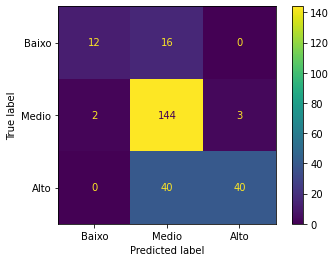

In [26]:
cf_matrix = confusion_matrix(patients_val_target, patients_val_pred, labels=range(n_classes))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = patients_target_pain)

cm_display.plot()
plt.show()

In [27]:
correct = []
incorrect = []
for i in range(len(patients_val_target)):
  pred_pain = patients_target_pain[patients_val_pred[i]].rsplit('_', 1)[-1]
  true_pain = patients_target_pain[patients_val_target[i]].rsplit('_', 1)[-1]
  if pred_pain == true_pain:
    correct.append(i)
  else:
    incorrect.append(i)
correct = np.array(correct)
incorrect = np.array(incorrect)
n_correct = correct.shape[0]
n_incorrect = incorrect.shape[0]
print(f'{n_correct} classificados corretamente')
print(f'{n_incorrect} classificados incorretamente')

196 classificados corretamente
61 classificados incorretamente


In [28]:
n_columns = 3
n_rows = np.ceil(n_incorrect/n_columns)

'''plt.figure(figsize=(1.8 * n_columns, 2.4 * n_rows)) 
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for j in range(n_incorrect):
    i = incorrect[j]
    plt.subplot(n_rows,n_columns,j+1) 
    plt.imshow(patients_val_data[i].reshape((altura_lfw, largura_lfw)), cmap='gray')
    plt.title('prev: %s\nreal: %s' % (patients_target_pain[patients_val_pred[i]].rsplit('_', 1)[-1], patients_target_pain[patients_val_target[i]].rsplit('_', 1)[-1]))
    plt.xticks(())
    plt.yticks(())
plt.show()'''

"plt.figure(figsize=(1.8 * n_columns, 2.4 * n_rows)) \nplt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)\n\nfor j in range(n_incorrect):\n    i = incorrect[j]\n    plt.subplot(n_rows,n_columns,j+1) \n    plt.imshow(patients_val_data[i].reshape((altura_lfw, largura_lfw)), cmap='gray')\n    plt.title('prev: %s\nreal: %s' % (patients_target_pain[patients_val_pred[i]].rsplit('_', 1)[-1], patients_target_pain[patients_val_target[i]].rsplit('_', 1)[-1]))\n    plt.xticks(())\n    plt.yticks(())\nplt.show()"